In [1]:
import numpy as np
import tensornetwork as tn
import torch
import torch.nn as nn
import copy

In [2]:
tn.set_default_backend("pytorch")

In [3]:
# класс для обработки изображений 

def make_tensor(nodes_list):
  c = nodes_list[0]   \
      @ nodes_list[1] \
      @ nodes_list[2] \
      @ nodes_list[3] \
      @ nodes_list[4] \
      @ nodes_list[5] \
      @ nodes_list[6] \
      @ nodes_list[7] \
      @ nodes_list[8] #@ nodes_list[9] @ nodes_list[10] @ nodes_list[11] @ nodes_list[12] @ nodes_list[13] @ nodes_list[14] @ nodes_list[15] @ nodes_list[16] @ nodes_list[17]
  make_edges(nodes_list)
  return c.tensor
    
def init_nodes(k = 9):
  nodes_list = list()

  with tn.NodeCollection(nodes_list):
    for i in range(k):
      a = tn.Node(nn.Parameter(torch.rand([1+3*(i==m) for m in range(k)], dtype=torch.float64), requires_grad= True))
  make_edges(nodes_list)
  
  return nodes_list


def make_edges(nodes_list, k = 9):    
  for i in range(k):
    for j in range(i+1,k):
      if i!=j:
        nodes_list[i][j] ^ nodes_list[j][i]


def loss_fn(X, nodes_list):
  Y = make_tensor(nodes_list)
  loss_func = nn.MSELoss()
  return loss_func(X, Y)


def fit(X,l,num_ep=100,k=9):
  optimizer = torch.optim.Adam([l[i].tensor for i in range(k)], lr=0.01)
  for ep in range(num_ep):
    optimizer.zero_grad()
    loss = loss_fn(X, l)
    loss.backward()
    optimizer.step()


def modify_node(node_tensor , index):
    z = list(node_tensor.shape)
    z[index] = 1
    prom = torch.rand(z, dtype=torch.float64)
    tensor = torch.cat((node_tensor, prom), index)
    return nn.Parameter(tensor, requires_grad= True)


def find_best_edge_and_modify_tn(X, nodes_list, num_iter_ep = 30, num_itog_ep = 100, k = 9):
  loss = loss_fn(X, nodes_list)
  best_i_j = (-1,-1)
  for i in range(k):
    for j in range(i+1,k):
      # print(i,j)
      new_nodes_list = copy.deepcopy(nodes_list)

      new_nodes_list[i].tensor = modify_node(new_nodes_list[i].tensor, j )
      new_nodes_list[j].tensor = modify_node(new_nodes_list[j].tensor, i )
      
      fit(X,new_nodes_list, num_iter_ep)
      
      mod_loss = loss_fn(X, new_nodes_list)
      
      if(mod_loss < loss):
        loss = mod_loss
        best_i_j = (i,j)
  
  i , j = best_i_j
  # print(i , j)
  
  if i == j :
    return False
  else:
    nodes_list[i].tensor = modify_node(nodes_list[i].tensor, j )
    nodes_list[j].tensor = modify_node(nodes_list[j].tensor, i )
    
    fit(X,nodes_list,num_itog_ep)
    
    return True

def coef(nodes_list, el= 512):
  sum = 0
  for i in nodes_list:
    sum += torch.prod(torch.tensor(i.tensor.shape))
  return sum / el**2

In [5]:
import matplotlib.pyplot as plt
import logging
from pgm import create_node
from pgm import create_node_from_pgm
from pgm import crop_pgm_image

In [6]:
logging.basicConfig(level=logging.DEBUG, filename='Experiment1' + '.log', filemode='w', format="%(levelname)s - %(message)s")

pgmf_path = "gray8bit_Dataset/"
file_list = ['nightshot_iso_100.pgm', 
             'leaves_iso_1600.pgm', 
             'leaves_iso_200.pgm', 
             'zone_plate.pgm']

In [7]:
%load_ext autoreload
%autoreload 2

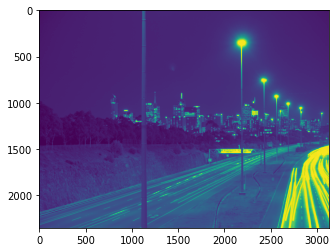

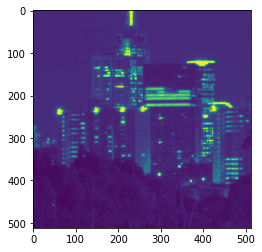

im_node.shape = (4, 4, 4, 4, 4, 4, 4, 4, 4)


In [8]:
file_name = next(enumerate(file_list))[1]
with open(pgmf_path + file_name, 'rb') as pgmf:
  im = plt.imread(pgmf)
  plt.imshow(im)
  plt.show()
  plt.imshow(crop_pgm_image(im))
  plt.show()
  im_node, _ = create_node_from_pgm(im, 4)
  print(f"im_node.shape = {im_node.shape}")

In [9]:
X = im_node.tensor
X = X.to(torch.float64)

Без увеличения размерности:


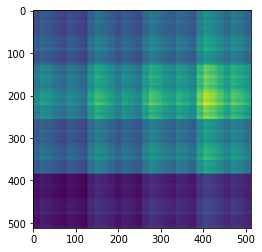

Loss: tensor(985.7921, dtype=torch.float64)
Coef: tensor(0.0001)
Увеличили размерность 5 раз(a):
Loss: tensor(809.7712, dtype=torch.float64)
Coef: tensor(0.0005)


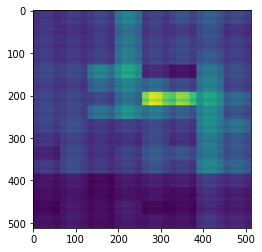

Увеличили размерность 10 раз(a):
Loss: tensor(546.8209, dtype=torch.float64)
Coef: tensor(0.0032)


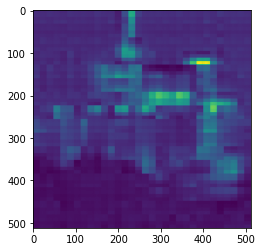

Увеличили размерность 15 раз(a):
Loss: tensor(304.6557, dtype=torch.float64)
Coef: tensor(0.0355)


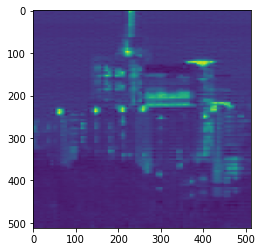

Увеличили размерность 20 раз(a):
Loss: tensor(80.5010, dtype=torch.float64)
Coef: tensor(0.1177)


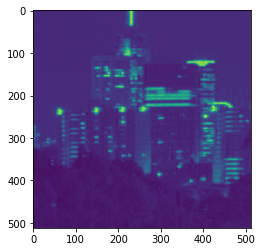

Увеличили размерность 25 раз(a):
Loss: tensor(38.2233, dtype=torch.float64)
Coef: tensor(0.7818)


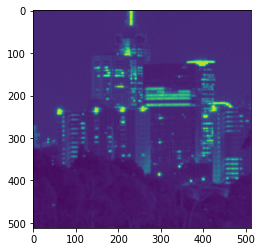

Увеличили размерность 30 раз(a):
Loss: tensor(2.8881, dtype=torch.float64)
Coef: tensor(2.4616)


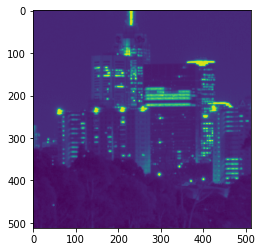

Увеличили размерность 35 раз(a):
Loss: tensor(0.8760, dtype=torch.float64)
Coef: tensor(5.4695)


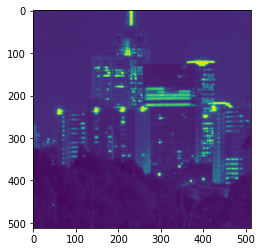

Увеличили размерность 40 раз(a):
Loss: tensor(0.2896, dtype=torch.float64)
Coef: tensor(10.6649)


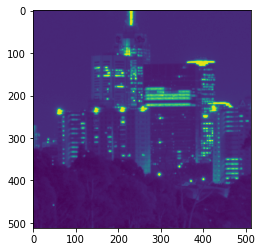

Увеличили размерность 45 раз(a):
Loss: tensor(0.1238, dtype=torch.float64)
Coef: tensor(16.2705)


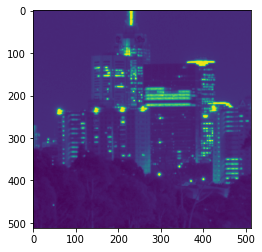

Увеличили размерность 50 раз(a):
Loss: tensor(0.0414, dtype=torch.float64)
Coef: tensor(24.6104)


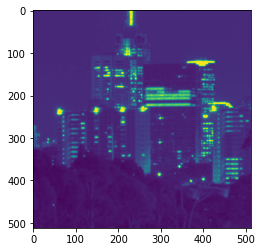

KeyboardInterrupt: 

In [10]:
l = init_nodes()
fit(X,l,num_ep=100,k=9)
Y = make_tensor(l)
print(f'Без увеличения размерности:')
plt.imshow(Y.detach().numpy().reshape(512,512))
plt.show()
print('Loss:', loss_fn(X, l).data)
print('Coef:', coef(l, 512).data)
memory_loss_list = [loss_fn(X, l)]
memory_nodes_list = [copy.deepcopy(l)]
memory_coef = [coef(l, 512)]
i = 0
flag = True
while flag:
    flag = find_best_edge_and_modify_tn(X, l, num_iter_ep = 100, num_itog_ep = 100)
    i += 1
    if i % 5 == 0:
      print(f'Увеличили размерность {i} раз(a):')
      Y = make_tensor(l)
      print('Loss:', loss_fn(X, l).data)
      print('Coef:', coef(l, 512).data)
      plt.imshow(Y.detach().numpy().reshape(512,512))
      plt.show()
      memory_loss_list.append(loss_fn(X, l))
      memory_nodes_list.append(copy.deepcopy(l))
      memory_coef.append(coef(l, 512))

print('Больше ребро не добавится в связи с выбором данного количества итераций.')
print('Итог:')
Y = make_tensor(l)
plt.imshow(Y.detach().numpy().reshape(512,512))
plt.show()
memory_loss_list.append(loss_fn(X, l))
memory_nodes_list.append(copy.deepcopy(l))
memory_coef.append(coef(l, 512))

Loss: tensor(0.0268, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Coef: tensor(27.0714)


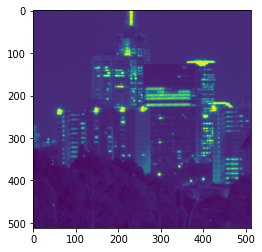

In [12]:
Y = make_tensor(l)
print('Loss:', loss_fn(X, l))
print('Coef:', coef(l, 512).data)
plt.imshow(Y.detach().numpy().reshape(512,512))
plt.show()

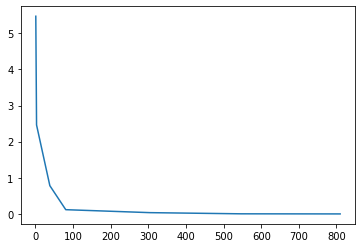

In [20]:
import matplotlib.pyplot as plt
plt.plot([loss.detach().numpy() for loss in memory_loss_list[1:8]], [coef.detach().numpy() for coef in memory_coef[1:8]])
plt.show()

Без увеличения размерности:


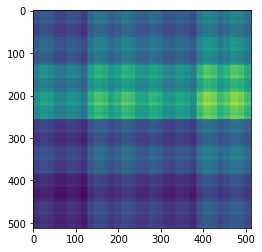

Loss: tensor(1024.6134, dtype=torch.float64)
Coef: tensor(0.0001)
Увеличили размерность 31 раз(a):
Loss: tensor(293.2023, dtype=torch.float64)
Coef: tensor(0.0194)


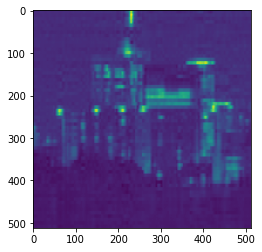

Увеличили размерность 32 раз(a):
Loss: tensor(283.7998, dtype=torch.float64)
Coef: tensor(0.0370)


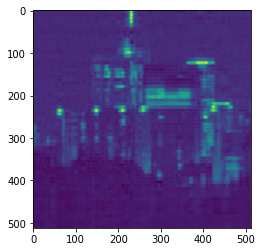

Увеличили размерность 33 раз(a):
Loss: tensor(191.4310, dtype=torch.float64)
Coef: tensor(0.0400)


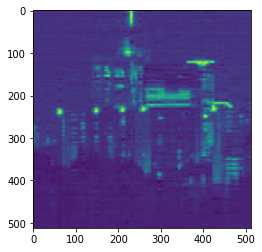

Увеличили размерность 34 раз(a):
Loss: tensor(171.5329, dtype=torch.float64)
Coef: tensor(0.0591)


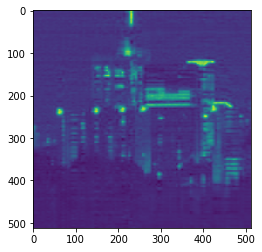

Увеличили размерность 35 раз(a):
Loss: tensor(145.9795, dtype=torch.float64)
Coef: tensor(0.0782)


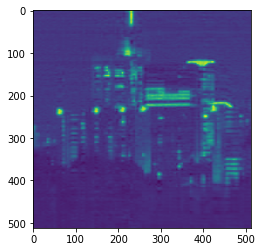

Увеличили размерность 36 раз(a):
Loss: tensor(118.1706, dtype=torch.float64)
Coef: tensor(0.0841)


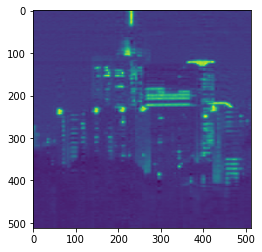

Увеличили размерность 37 раз(a):
Loss: tensor(100.1686, dtype=torch.float64)
Coef: tensor(0.0900)


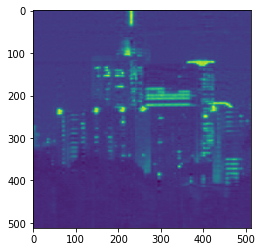

Увеличили размерность 38 раз(a):
Loss: tensor(91.0715, dtype=torch.float64)
Coef: tensor(0.0959)


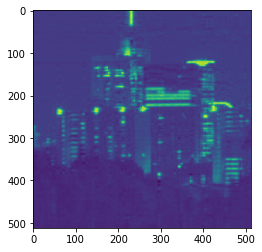

Увеличили размерность 39 раз(a):
Loss: tensor(84.1895, dtype=torch.float64)
Coef: tensor(0.1019)


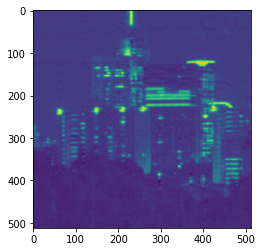

Увеличили размерность 40 раз(a):
Loss: tensor(81.9744, dtype=torch.float64)
Coef: tensor(0.1517)


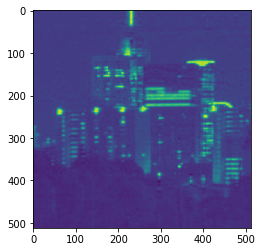

Увеличили размерность 41 раз(a):
Loss: tensor(67.3075, dtype=torch.float64)
Coef: tensor(0.1606)


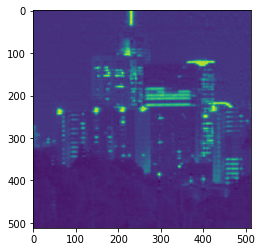

Увеличили размерность 42 раз(a):
Loss: tensor(60.6311, dtype=torch.float64)
Coef: tensor(0.1694)


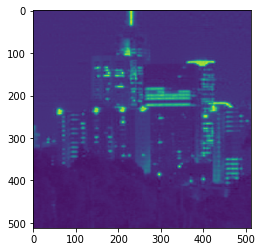

Увеличили размерность 43 раз(a):
Loss: tensor(55.9515, dtype=torch.float64)
Coef: tensor(0.1783)


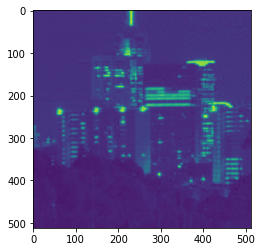

Увеличили размерность 44 раз(a):
Loss: tensor(52.3104, dtype=torch.float64)
Coef: tensor(0.1871)


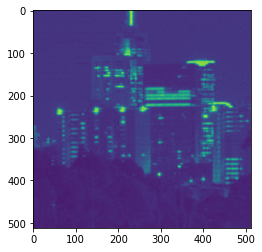

Увеличили размерность 45 раз(a):
Loss: tensor(51.3202, dtype=torch.float64)
Coef: tensor(0.2487)


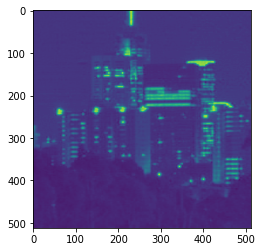

Увеличили размерность 46 раз(a):
Loss: tensor(45.1954, dtype=torch.float64)
Coef: tensor(0.2604)


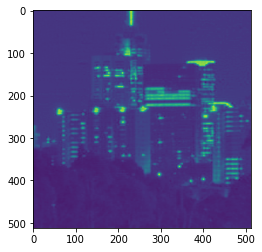

Увеличили размерность 47 раз(a):
Loss: tensor(41.5809, dtype=torch.float64)
Coef: tensor(0.2722)


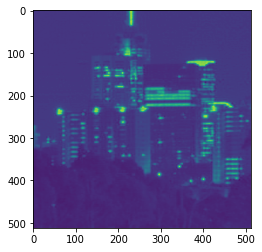

Увеличили размерность 48 раз(a):
Loss: tensor(41.1438, dtype=torch.float64)
Coef: tensor(0.3621)


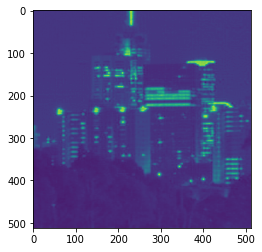

Увеличили размерность 49 раз(a):
Loss: tensor(35.0893, dtype=torch.float64)
Coef: tensor(0.3778)


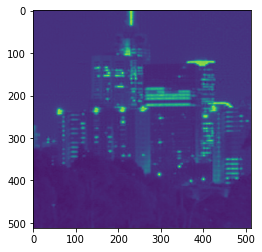

Увеличили размерность 50 раз(a):
Loss: tensor(32.1159, dtype=torch.float64)
Coef: tensor(0.4716)


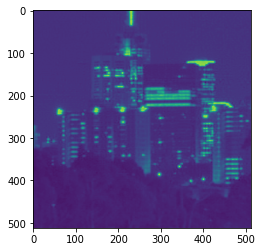

Увеличили размерность 51 раз(a):
Loss: tensor(28.2362, dtype=torch.float64)
Coef: tensor(0.4912)


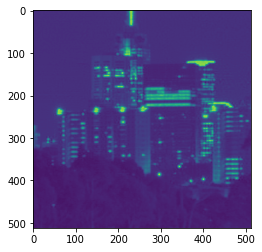

Увеличили размерность 52 раз(a):
Loss: tensor(26.0032, dtype=torch.float64)
Coef: tensor(0.5108)


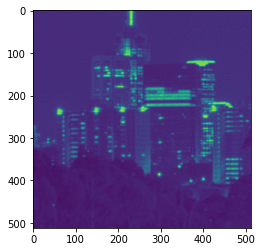

Увеличили размерность 53 раз(a):
Loss: tensor(24.4270, dtype=torch.float64)
Coef: tensor(0.5304)


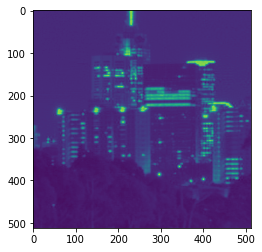

KeyboardInterrupt: 

In [21]:
#проведём ещё один эксперемент и теперь будем запоминать значения при лоссе меньшим 200 а потом зафайтюним модельку
list_of_node = init_nodes()
fit(X,list_of_node,num_ep=100,k=9)
Y = make_tensor(list_of_node)
print(f'Без увеличения размерности:')
plt.imshow(Y.detach().numpy().reshape(512,512))
plt.show()
print('Loss:', loss_fn(X, list_of_node).data)
print('Coef:', coef(list_of_node, 512).data)
history_loss_list = [loss_fn(X, list_of_node)]
history_nodes_list = [copy.deepcopy(list_of_node)]
history_coef = [coef(list_of_node, 512)]
i = 0
while coef(list_of_node, 512)<1:
    find_best_edge_and_modify_tn(X, list_of_node, num_iter_ep = 100, num_itog_ep = 100)
    i += 1
    if loss_fn(X, list_of_node)<300:
        print(f'Увеличили размерность {i} раз(a):')
        Y = make_tensor(list_of_node)
        print('Loss:', loss_fn(X, list_of_node).data)
        print('Coef:', coef(list_of_node, 512).data)
        plt.imshow(Y.detach().numpy().reshape(512,512))
        plt.show()
        history_nodes_list.append(copy.deepcopy(list_of_node))
        history_loss_list.append(loss_fn(X, list_of_node))
        history_coef.append(coef(list_of_node, 512))

print('Итог:')
print('Loss:', loss_fn(X, list_of_node).data)
print('Coef:', coef(list_of_node, 512).data)
Y = make_tensor(list_of_node)
plt.imshow(Y.detach().numpy().reshape(512,512))
plt.show()
history_loss_list.append(loss_fn(X, list_of_node))
history_nodes_list.append(copy.deepcopy(list_of_node))
history_coef.append(coef(list_of_node, 512))

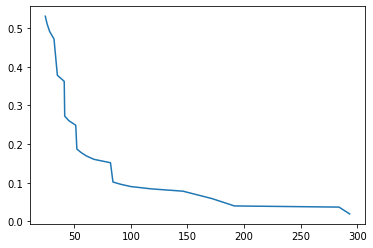

In [23]:
import matplotlib.pyplot as plt
plt.plot([loss.detach().numpy() for loss in history_loss_list[1:]], [coef.detach().numpy() for coef in history_coef[1:]])
plt.show()

In [25]:
#файнтюним 
fine_history_loss_list = []
fine_history_coef = []
for model in history_nodes_list:
    fit(X, model, 1000)
    fine_history_loss_list.append(loss_fn(X, model))
    fine_history_coef.append(coef(model, 512))

ValueError: No edges found between nodes '__unnamed_node__' and '__unnamed_node__' and allow_outer_product=False.

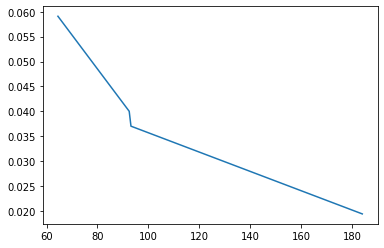

In [26]:
import matplotlib.pyplot as plt
plt.plot([loss.detach().numpy() for loss in fine_history_loss_list[1:]], [coef.detach().numpy() for coef in fine_history_coef[1:]])
plt.show()